C:\Users\ASUS\AppData\Local\Temp\ipykernel_22388\1571052190.py:14: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate(method='linear', inplace=True)


Linear Regression Test RMSE: 21.730, R2: 0.771
Fitting 2 folds for each of 8 candidates, totalling 16 fits
Best Random Forest params: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
Best CV R2 score: 0.8841375111048404
Random Forest Test RMSE: 14.307, R2: 0.901


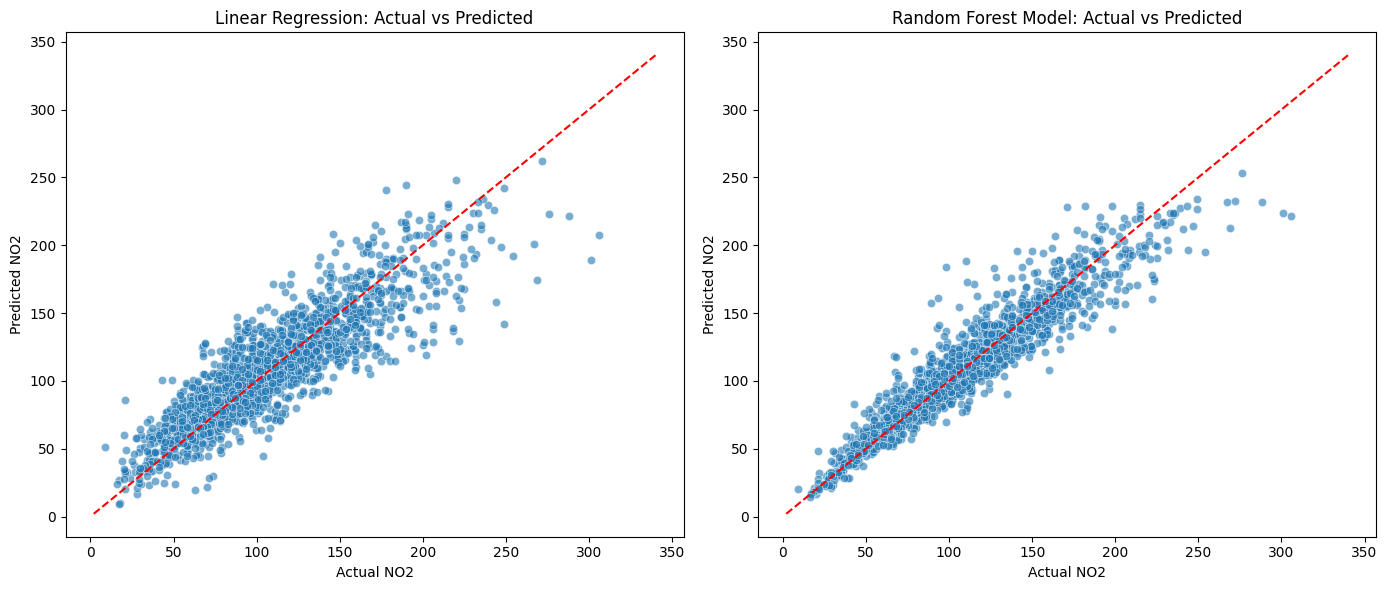

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess data (adjust path as needed)
df = pd.read_csv('AirQualityUCI.csv', sep=';', decimal=',', na_values=-200)
df = df.iloc[:, :-2]  # drop last two empty columns
df.interpolate(method='linear', inplace=True)
df.dropna(inplace=True)

# Original features and target
features = ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH']
target = 'NO2(GT)'

# Add lag features (lags 1 to 2 for faster processing)
for lag in range(1, 3):
    for col in features:
        df[f'{col}_lag{lag}'] = df[col].shift(lag)
df.dropna(inplace=True)

# Prepare feature matrix and target vector
X = df[[f for f in df.columns if f != target and f != 'Date' and f != 'Time']]
y = df[target]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)
print(f"Linear Regression Test RMSE: {rmse_lr:.3f}, R2: {r2_lr:.3f}")

# Random Forest with RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 15, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(
    rf, param_dist, n_iter=8, cv=2, scoring='r2', n_jobs=-1, random_state=42, verbose=1
)
random_search.fit(X_train, y_train)

print("Best Random Forest params:", random_search.best_params_)
print("Best CV R2 score:", random_search.best_score_)

best_rf = random_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest Test RMSE: {rmse_rf:.3f}, R2: {r2_rf:.3f}")

# If Random Forest R2 < 0.80, try XGBoost
if r2_rf < 0.80:
    xgb_model = xgb.XGBRegressor(random_state=42, n_estimators=150, max_depth=10)
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)
    rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
    r2_xgb = r2_score(y_test, y_pred_xgb)
    print(f"XGBoost Test RMSE: {rmse_xgb:.3f}, R2: {r2_xgb:.3f}")
    y_pred_final = y_pred_xgb
    model_name = "XGBoost"
else:
    y_pred_final = y_pred_rf
    model_name = "Random Forest"

# Plot all three: Linear Regression and best model (RF or XGB)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=y_pred_lr, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Actual NO2')
plt.ylabel('Predicted NO2')
plt.title('Linear Regression: Actual vs Predicted')

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=y_pred_final, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Actual NO2')
plt.ylabel('Predicted NO2')
plt.title(f'{model_name} Model: Actual vs Predicted')

plt.tight_layout()
plt.show()
